# This notebook contains the code which prepares training and test datasets for a model trained with the sentence embedding technique, as well as trains and evaluates this model

## Connect the notebook to MyDrive




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import all necessary libraries

In [2]:
# Import # Standard python libraries for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Custom module
import sys
sys.path.insert(0,'/content/drive/MyDrive/python_project/code')
from models import InferSent

# Libraries to build, train, evaluate, and save an ML model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pickle
import torch

import warnings
warnings.filterwarnings('ignore')

## Load train and test datasets


In [3]:
# Import train dataset into pandas DataFrame
train_df = pd.read_csv("drive/MyDrive/python_project/data/train_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(train_df.head())

# Import test dataset into pandas DataFrame
test_df = pd.read_csv("drive/MyDrive/python_project/data/test_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(test_df.head())

                                            dialogue     name
0   I’ll say it looks good. It’s in my proprietar...  Sheldon
1   Wait, wait, wait. When did you send my mom no...  Leonard
2            I never had a beer with my dad, either.   Howard
3                      My thank you was not sincere.  Sheldon
4   I’m calling to invite you to a spontaneous da...  Sheldon
                                            dialogue     name
0                      Yeah, that’s when it started.  Leonard
1   A million dollars? God, it’s like my nuts jus...   Howard
2   Dinner’s almost ready. If you like meatloaf, ...   Howard
3   Well, Leonard, I think it’s high time you and...  Sheldon
4              All right. It is a comfortable chair.  Sheldon


## Feature engineering

## Download and unzip word embedding model GloVe

In [4]:
!curl -Lo drive/MyDrive/python_project/GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip drive/MyDrive/python_project/GloVe/glove.840B.300d.zip -d drive/MyDrive/python_project/GloVe/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   353    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2075M  100 2075M    0     0  4717k      0  0:07:30  0:07:30 --:--:-- 5217k
Archive:  drive/MyDrive/python_project/GloVe/glove.840B.300d.zip
  inflating: drive/MyDrive/python_project/GloVe/glove.840B.300d.txt  


## Initialize the model

### Download the InferSent model using the following code: <br>
`!curl -Lo drive/MyDrive/python_project/code/encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl` <br>
`!curl -Lo drive/MyDrive/python_project/code/encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl`

In [5]:
# Initialize the InterSent model
model_version = 1
MODEL_PATH = f"drive/MyDrive/python_project/code/encoder/infersent{model_version}.pkl"
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

In [6]:
# Select GPU in the Edit -> Notebook Settings
model = model.cuda()

In [7]:
# Use GloVe embedding
W2V_PATH = 'drive/MyDrive/python_project/GloVe/glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

In [8]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


## Prepare train and test datasets for the model to train with sentence embedding technique

In [9]:
# Get a list of dialogues and names from the train dataset
train_dialogues = train_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
train_names = train_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(train_dialogues[:5])
print(train_names[:5])

# Get a list of dialogues and names from the test dataset
test_dialogues = test_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
test_names = test_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(test_dialogues[:5])
print(test_names[:5])

[' i’ll say it looks good. it’s in my proprietary font, shelvetica.', ' wait, wait, wait. when did you send my mom notes on a paper?', ' i never had a beer with my dad, either.', ' my thank you was not sincere.', ' i’m calling to invite you to a spontaneous date night tomorrow evening.']
['sheldon', 'leonard', 'howard', 'sheldon', 'sheldon']
[' yeah, that’s when it started.', ' a million dollars? god, it’s like my nuts just kicked me in the nuts. that’s it, i got to start earning more money right now.', ' dinner’s almost ready. if you like meatloaf, i’m sure you’ll like its cousin, bowl of meat.', ' well, leonard, i think it’s high time you and i address the tweepadock in the room.', ' all right. it is a comfortable chair.']
['leonard', 'howard', 'howard', 'sheldon', 'sheldon']


### Get train features

In [10]:
train_features = model.encode(train_dialogues, bsize=128, tokenize=False, verbose=True)
print(f'nb sentences encoded : {len(train_features)}')

Nb words kept : 186686/246560 (75.7%)
Speed : 3065.8 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 18468


### Get test features

In [11]:
test_features = model.encode(test_dialogues, bsize=128, tokenize=False, verbose=True)
print(f'nb sentences encoded : {len(test_features)}')

Nb words kept : 45874/60522 (75.8%)
Speed : 3334.7 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 4596


## Train the model with seq2seq technique

In [12]:
# Make an instance of the Model
lr_seq2seq = LogisticRegression()

# Train the model
lr_seq2seq.fit(train_features, train_names)

# Print the labels
print(lr_seq2seq.classes_)

# Print parameters of the model
print(lr_seq2seq.get_params())

['howard' 'leonard' 'penny' 'sheldon']
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Save the Logistic Regression model trained with sentence embedding technique

In [13]:
with open("drive/MyDrive/python_project/lr_seq2seq_model.pkl", 'wb') as file:
    pickle.dump(lr_seq2seq, file)

## Evaluate the Logistic Regression moded trained with sentence embedding technique

### Accuracy

In [14]:
# Train a logistic regression model using TfidfVectorizer features
predictions_lr = lr_seq2seq.predict(test_features)
seq2seq_accuracy = accuracy_score(test_names, predictions_lr)
print("Accuracy of the Logistic Regression model trained with Seq2Seq:", seq2seq_accuracy)


Accuracy of the Logistic Regression model trained with Seq2Seq: 0.3522628372497824


### Confusion matrix visualization

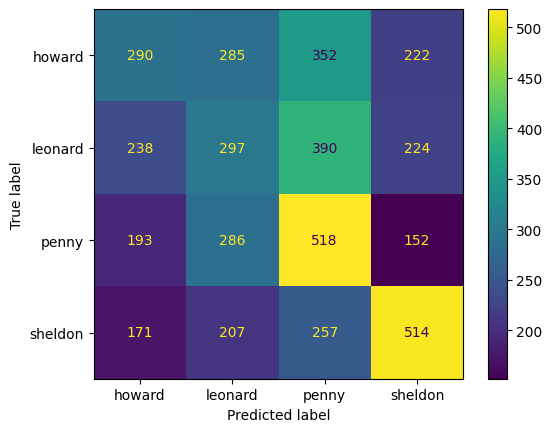

In [15]:
# Get the labels
labels = lr_seq2seq.classes_
# Get the confusion matrix
cm = confusion_matrix(test_names, predictions_lr, labels=labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Get classification report

In [16]:
# Print the classification report
print(classification_report(test_names, predictions_lr))

              precision    recall  f1-score   support

      howard       0.33      0.25      0.28      1149
     leonard       0.28      0.26      0.27      1149
       penny       0.34      0.45      0.39      1149
     sheldon       0.46      0.45      0.45      1149

    accuracy                           0.35      4596
   macro avg       0.35      0.35      0.35      4596
weighted avg       0.35      0.35      0.35      4596

